In [1]:
import qsample as qs
import time
import stim
import numpy as np
import matplotlib.pyplot as plt
import time
import re
from tqdm.notebook import tqdm
import random

In [2]:
eft = qs.Circuit("""R 0 1 2 3 4 5 6 7
H 0 1 3
                        CNOT 0 4
                        CNOT 1 2
                        TICK
                        CNOT 3 5
                        TICK
                        CNOT 0 6
                        TICK
                        CNOT 3 4
                        TICK
                        CNOT 1 5
                        TICK
                        CNOT 0 2
                        TICK
                        CNOT 5 6
                        TICK
                        CNOT 4 7
                        TICK
                        CNOT 2 7
                        TICK
                        CNOT 5 7
                        M 7""")

sz_123 = qs.Circuit("""R 8
CNOT 0 8
                        TICK
                        CNOT 1 8
                        TICK
                        CNOT 3 8
                        TICK
                        CNOT 6 8
                            M 8""")

meas7 = qs.Circuit("""M 0 1 2 3 4 5 6""", noisy=False)





k1 = 0b0001111
k2 = 0b1010101
k3 = 0b0110011
k12 = k1 ^ k2
k23 = k2 ^ k3
k13 = k1 ^ k3
k123 = k12 ^ k3
stabilizerGenerators = [k1, k2, k3]
stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

def hamming2(x, y):
    count, z = 0, x ^ y
    while z:
        count += 1
        z &= z - 1
    return count

fails = []
def logErr(out):
    global fails
    c = np.array([hamming2(out, i) for i in stabilizerSet])
    d = np.flatnonzero(c <= 1)
    e = np.array([hamming2(out ^ (0b1111111), i) for i in stabilizerSet])
    f = np.flatnonzero(e <= 1)
    if len(d) != 0:
        return False
    elif len(f) != 0:
        fails.append(out)
        return True
    if len(d) != 0 and len(f) != 0: 
        raise('-!-!-CANNOT BE TRUE-!-!-')

def flagged_z_look_up_table_1(z):
    s = [z]

    if s == [1]:
        return True
    else: 
        return False

functions = {"logErr": logErr, "lut": flagged_z_look_up_table_1}

steane0 = qs.Protocol(check_functions=functions, fault_tolerant=True)

steane0.add_nodes_from(['ENC', 'Z2', 'meas'], circuits=[eft, sz_123, meas7])
steane0.add_node('X_COR', circuit=qs.Circuit("""X 6""", noisy=True))
steane0.add_edge('START', 'ENC', check='True')
steane0.add_edge('ENC', 'meas', check='ENC[-1]==0')
steane0.add_edge('ENC', 'Z2', check='ENC[-1]==1')
steane0.add_edge('Z2', 'X_COR', check='lut(Z2[-1])')
steane0.add_edge('Z2', 'meas', check='not lut(Z2[-1])')
steane0.add_edge('X_COR', 'meas', check='True')
steane0.add_edge('meas', 'FAIL', check='logErr(meas[-1])')

In [3]:
err_model = qs.noise.E1
q = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5]
err_params = {'q': q}

begin = time.time()
stim_sam = qs.SubsetSampler(protocol=steane0, simulator=qs.StimSimulator,  p_max={'q': 0.1}, err_model=err_model, err_params=err_params, L=3)
stim_sam.run(2000)
end = time.time()
stim_time = end-begin

v2 = stim_sam.stats()[0]
w2 = stim_sam.stats()[2]

p=('1.00e-01',):   0%|          | 0/2000 [00:00<?, ?it/s]

0: {}
1: {'X': {0}}
2: {}
3: {}
4: {'Z': {3}, 'X': {5}}
5: {}
6: {'Y': {4}}
7: {}
8: {}
9: {}
10: {}
11: {}
12: {'X': {5}, 'Y': {7}}
13: {}


ValueError: Index is out of range. Need -len(circuit) <= index <= len(circuit).
    index=9
    len(circuit)=7

In [14]:
aa = stim.Circuit('''
    R 0 1 2 3 4 5 6 7
    H 0 1 3
    Z 0
    X 0''')
len(aa)

4

In [3]:
qiw = qs.Circuit([{'Y': {5}, 'X': {6}}])
for tick in qiw._ticks:
    print(tick.keys())
qiw.stim_circuit

dict_keys(['Y', 'X'])


stim.Circuit('''
    Y 5
    X 5
''')

In [4]:
eft = qs.Circuit([  {"init": {0,1,2,4,3,5,6,7}},
                    {"H": {0,1,3}},
                    {"CNOT": {(0,4)}},
                    {"CNOT": {(1,2)}},
                    {"CNOT": {(3,5)}},
                    {"CNOT": {(0,6)}},
                    {"CNOT": {(3,4)}},
                    {"CNOT": {(1,5)}},
                    {"CNOT": {(0,2)}},
                    {"CNOT": {(5,6)}},
                    {"CNOT": {(4,7)}},
                    {"CNOT": {(2,7)}},
                    {"CNOT": {(5,7)}},
                    {"measure": {7}} ])

sz_123 = qs.Circuit([   {"init": {8}},
                        {"CNOT": {(0,8)}},
                        {"CNOT": {(1,8)}},
                        {"CNOT": {(3,8)}},
                        {"CNOT": {(6,8)}},
                        {"measure": {8}}])

meas7 = qs.Circuit([ {"measure": {0,1,2,3,4,5,6}} ], noisy=False)





k1 = 0b0001111
k2 = 0b1010101
k3 = 0b0110011
k12 = k1 ^ k2
k23 = k2 ^ k3
k13 = k1 ^ k3
k123 = k12 ^ k3
stabilizerGenerators = [k1, k2, k3]
stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

def hamming2(x, y):
    count, z = 0, x ^ y
    while z:
        count += 1
        z &= z - 1
    return count

fails = []

def logErr(out):
    global fails
    
    c = np.array([hamming2(out, i) for i in stabilizerSet])
    d = np.flatnonzero(c <= 1)
    e = np.array([hamming2(out ^ (0b1111111), i) for i in stabilizerSet])
    f = np.flatnonzero(e <= 1)
    if len(d) != 0:
        return False
    elif len(f) != 0:
        fails.append(out)
        return True
    if len(d) != 0 and len(f) != 0: 
        raise('-!-!-CANNOT BE TRUE-!-!-')

def flagged_z_look_up_table_1(z):
    s = [z]

    if s == [1]:
        return True
    else: 
        return False

functions = {"logErr": logErr, "lut": flagged_z_look_up_table_1}

steane0 = qs.Protocol(check_functions=functions, fault_tolerant=True)

steane0.add_nodes_from(['ENC', 'Z2', 'meas'], circuits=[eft, sz_123, meas7])
steane0.add_node('X_COR', circuit=qs.Circuit([{'X': {6}}], noisy=True))
steane0.add_edge('START', 'ENC', check='True')
steane0.add_edge('ENC', 'meas', check='ENC[-1]==0')
steane0.add_edge('ENC', 'Z2', check='ENC[-1]==1')
steane0.add_edge('Z2', 'X_COR', check='lut(Z2[-1])')
steane0.add_edge('Z2', 'meas', check='not lut(Z2[-1])')
steane0.add_edge('X_COR', 'meas', check='True')
steane0.add_edge('meas', 'FAIL', check='logErr(meas[-1])')

In [5]:
err_model = qs.noise.E1
q = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5]
err_params = {'q': q}

begin = time.time()
ss_sam = qs.SubsetSampler(protocol=steane0, simulator=qs.StabilizerSimulator,  p_max={'q': 0.1}, err_model=err_model, err_params=err_params, L=3)
ss_sam.run(2000)
end = time.time()
qsample_time = end-begin

v1 = ss_sam.stats()[0]
w1 = ss_sam.stats()[2]

p=('1.00e-01',):   0%|          | 0/2000 [00:00<?, ?it/s]

1.872802972793579
1.9106721878051758


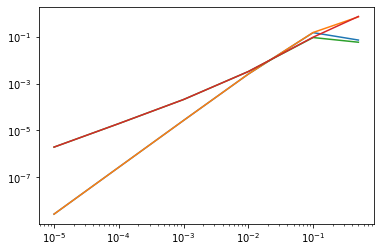

In [6]:
plt.plot(q, v1)
plt.plot(q, w1)
plt.plot(q, v2)
plt.plot(q, w2)

plt.xscale('log')
plt.yscale('log')

print(qsample_time)
print(stim_time)

In [ ]:
qsample_times = []
stim_times = []

samples = [100, 300, 1000, 3000, 10000, 50000]

for s in samples:
    begin = time.time()
    ss_sam = qs.SubsetSampler(protocol=steane0, simulator=qs.StabilizerSimulator,  p_max={'q': 0.01}, err_model=err_model, err_params=err_params, L=3)
    ss_sam.run(s)
    end = time.time()
    qsample_times.append(end-begin)

    begin = time.time()
    ss_sam = qs.SubsetSampler(protocol=steane0, simulator=qs.StimSimulator,  p_max={'q': 0.01}, err_model=err_model, err_params=err_params, L=3)
    ss_sam.run(s)
    end = time.time()
    stim_times.append(end-begin)

In [ ]:
plt.plot(samples, qsample_times, label = 'stabilizer sim.')
plt.plot(samples, stim_times, label = 'stim sim.')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('time (s)')
plt.xlabel('# of samples')

print('Average ratio of stim time/stabilizer time: {:.2f}'.format(np.average(np.array(stim_times)/np.array(qsample_times))))